In [1]:
import sys
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import time

In [2]:
from segment_anything import sam_model_registry, SamPredictor

### SAM Mask Layover Function

In [3]:
def show_anns(anns,display="all",mask_num=0):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    if display == "all":
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    elif display == "single_mask":
        ann = sorted_anns[mask_num]
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

# Load SAM Model ViT_H

In [12]:
sam_h = sam_model_registry["vit_h"](checkpoint="models/vit_h/sam_vit_h_4b8939.pth")
mask_h_predictor = SamPredictor(sam_h)

# Load SAM Model ViT_L

In [13]:
sam_l = sam_model_registry["vit_l"](checkpoint="models/vit_l/sam_vit_l_0b3195.pth")
mask_l_predictor = SamPredictor(sam_l)

# Load SAM Model ViT_B

In [4]:
sam_b = sam_model_registry["vit_b"](checkpoint="models/vit_b/sam_vit_b_01ec64.pth")
mask_b_predictor = SamPredictor(sam_b)

# Testing!

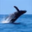

In [5]:
test1_image = "/Users/elirotondo/Documents/GitHub/ece590_fall2024/datasets/c100_extracted/images/fin_whale_s_000867.png"
t1_img = Image.open(test1_image)
display(t1_img)
t1_img = np.array(t1_img)

In [16]:
start_time = time.time()
mask_h_predictor.set_image(t1_img)
input_point = np.array([[16, 16]])
input_label = np.array([1])
h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print("Time: " + str(round(time.time() - start_time,2)))

Time: 26.54


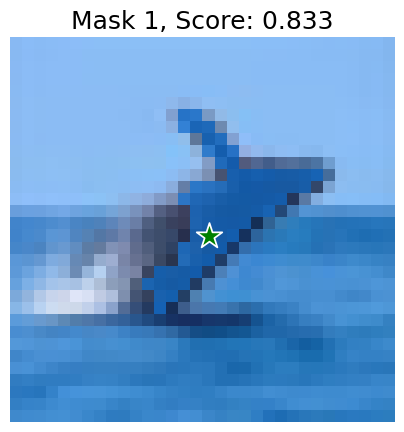

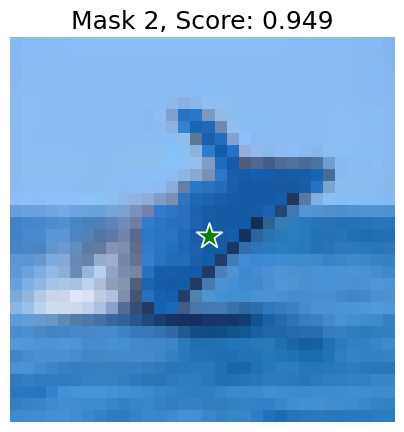

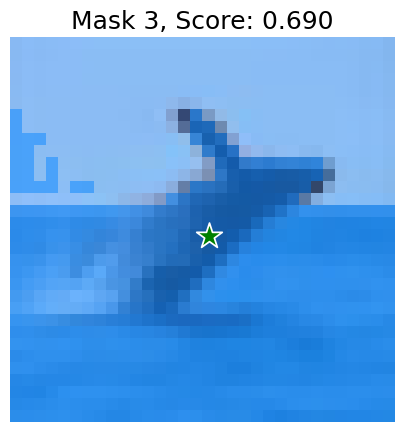

In [17]:
for i, (mask, score) in enumerate(zip(h_t1_masks, h_t1_scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(t1_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [18]:
start_time = time.time()
mask_l_predictor.set_image(t1_img)
input_point = np.array([[16, 16]])
input_label = np.array([1])
l_t1_masks, l_t1_scores, l_t1_logits = mask_l_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print("Time: " + str(round(time.time() - start_time,2)))

Time: 19.14


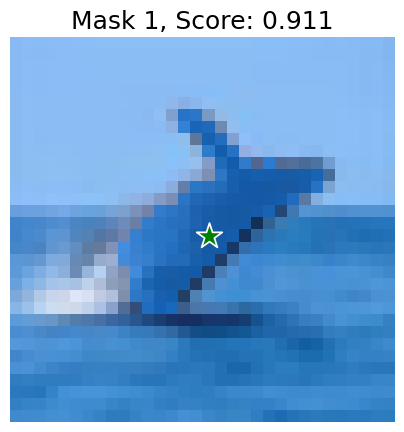

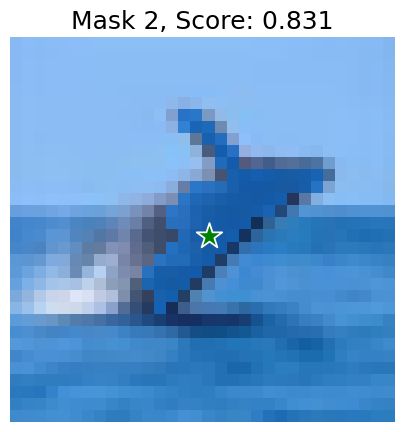

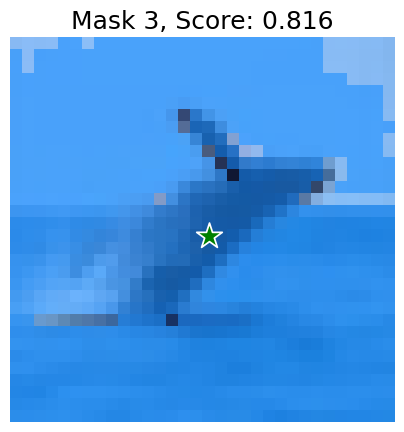

In [19]:
for i, (mask, score) in enumerate(zip(l_t1_masks, l_t1_scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(t1_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [6]:
start_time = time.time()
mask_b_predictor.set_image(t1_img)
input_point = np.array([[16, 16]])
input_label = np.array([1])
b_t1_masks, b_t1_scores, b_t1_logits = mask_b_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print("Time: " + str(round(time.time() - start_time,2)))

Time: 9.68


In [12]:
np.argmax(b_t1_scores)

1

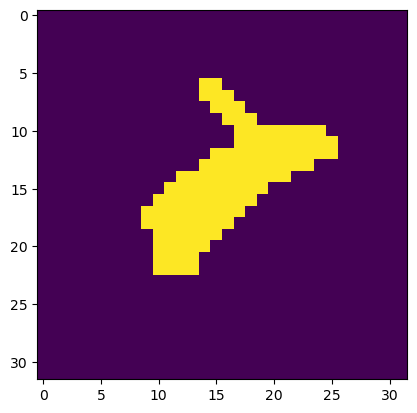

In [ ]:
plt.imshow(b_t1_masks[np.argmax(b_t1_scores),:,:])
plt.show()

In [20]:
b_t1_masks[np.argmax(b_t1_scores),:,:].shape

(32, 32)

In [54]:
best_mask = np.stack((b_t1_masks[np.argmax(b_t1_scores),:,:],)*3, axis=-1)
cropped = t1_img * best_mask

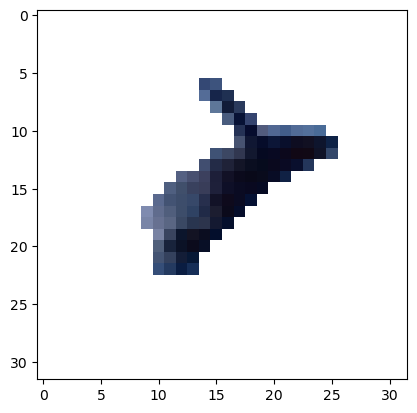

In [97]:
cropped[cropped==0] = 255
plt.imshow(cropped)
plt.show()

In [102]:
mask = b_t1_masks[np.argmax(b_t1_scores),:,:].copy()
new_mask = mask.copy()
new_mask[:,1:] = mask[:,1:]+mask[:,:-1]
new_mask[1:,:] = new_mask[1:,:]+mask[:-1,:]
new_mask[:,1:] = new_mask[:,1:]+mask[:,:-1]

In [103]:
from scipy.signal import convolve2d
padded_mask_1 = convolve2d(mask,np.ones((3,3)),mode="same")
padded_mask_1[padded_mask_1>0] = 1

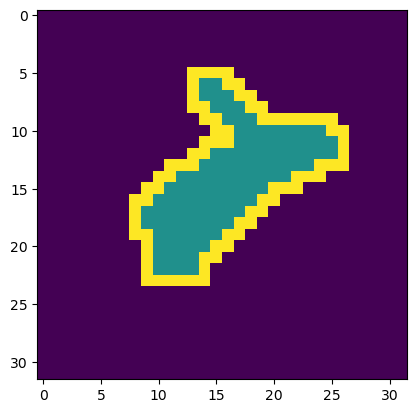

In [96]:
#plt.imshow(new_mask)
mask_int = b_t1_masks[np.argmax(b_t1_scores),:,:].copy().astype(float)
mask_int[mask_int==1] = 0.5
mask_int[mask_int==0] = 1
plt.imshow(padded_mask_1*mask_int)
plt.show()

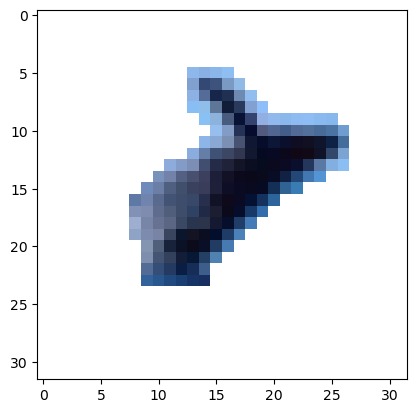

In [107]:
best_mask_padded = np.stack((padded_mask_1,)*3, axis=-1)
cropped_2 = t1_img * best_mask_padded
cropped_2[cropped_2==0] = 255
cropped_2 = cropped_2.astype(int)
plt.imshow(cropped_2)
plt.show()

In [44]:
print(cropped.shape)
print(t1_img.shape)

(32, 32, 3)
(32, 32, 3)


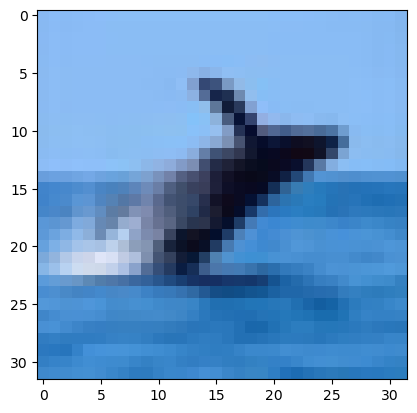

In [36]:
plt.imshow(t1_img)
plt.show()

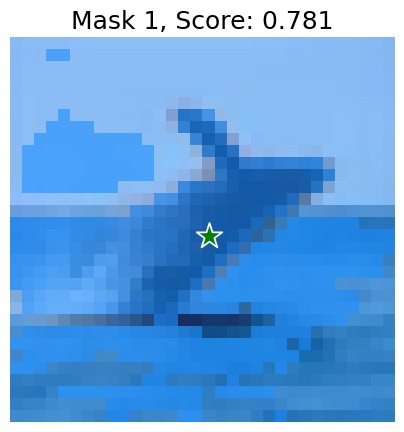

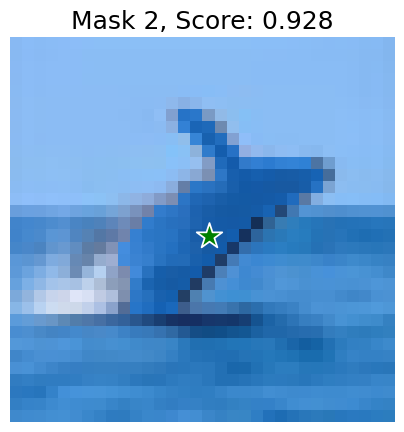

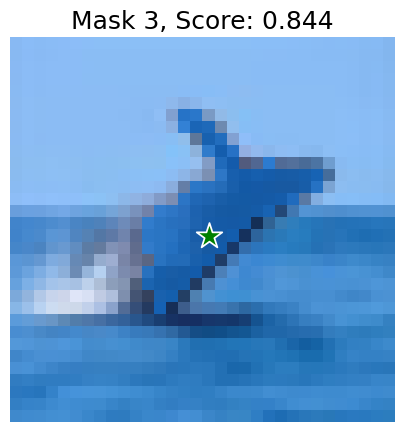

In [7]:
for i, (mask, score) in enumerate(zip(b_t1_masks, b_t1_scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(t1_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 